In [3]:
import json
import os
import urllib
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import cv2
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import urllib.request
from zipfile import ZipFile
import glob

In [8]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [10]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "automlgpu"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', 
                                                           idle_seconds_before_scaledown=1800,
                                                           min_nodes=0, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [11]:
compute_target.provisioning_state

'Succeeded'

In [13]:
compute_target.vm_size

'STANDARD_NC6'

In [14]:
from azureml.core import Experiment

experiment_name = 'AutomlImages-Parkinson' 
experiment = Experiment(ws, name=experiment_name)

In [17]:
os.mkdir('ImagesParkinson')
os.chdir('ImagesParkinson')

In [18]:
zip_file='parkinson.zip'

with ZipFile(zip_file, 'r') as zip:
    print('>> Unzip the zip file...')
    zip.extractall()
    print('Done!')

print("\n>> Deleting the zip file...")
os.remove(zip_file)
print("Done!")

>> Unzip the zip file...
Done!

>> Deleting the zip file...
Done!


In [19]:
print(os.listdir('.'))

['Testing', 'Training']



found 94 images.
Using 4 threads. (max:4)



100%|██████████| 94/94 [00:00<00:00, 105.27it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  94

dtype                                    |  uint8
channels                                 |  [3, 4]
extensions                               |  ['png']

min height                               |  251
max height                               |  256
mean height                              |  255.90425531914894
median height                            |  256

min width                                |  253
max width                                |  260
mean width                               |  255.9787234042553
median width                             |  256

mean height/width ratio                  |  0.9997090848641011
median height/width ratio                |  1.0
recommended input size(by mean)          |  [256 256] (h x w, multiples of 8)
recommended input size(by mean)          |  [256 256] (h x w, multiples of 16)
recommended input size(by

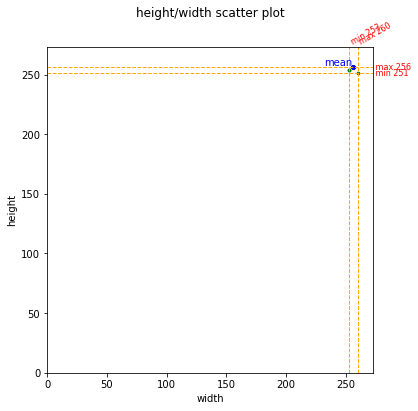

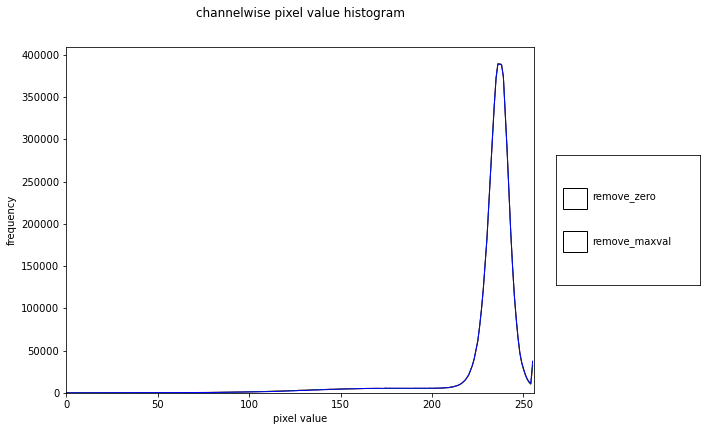

In [20]:
from basic_image_eda import BasicImageEDA

if __name__ == "__main__":  # for multiprocessing
    data_dir = "Training"
    
    extensions = ['png', 'jpg', 'jpeg']
    threads = 0
    dimension_plot = True
    channel_hist = True
    nonzero = False
    hw_division_factor = 1.0

    BasicImageEDA.explore(data_dir, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

In [21]:
for root, _, files in os.walk('.'):
    print("Dir:", root, "with", len(files), "images files.")

Dir: . with 0 images files.
Dir: ./Testing with 8 images files.
Dir: ./Training with 0 images files.
Dir: ./Training/healthy with 47 images files.
Dir: ./Training/parkinson with 47 images files.


In [167]:
def imageview(filename):
    imgdisplay = cv2.imread(filename)
    print('Image:', filename, 'Image Size:', imgdisplay.shape)
    plt.figure(figsize=(5, 5)) 
    image_rgb2 = cv2.cvtColor(imgdisplay, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb2)

Image: Training/healthy/healthy (1).png Image Size: (256, 256, 3)
Image: Training/healthy/healthy (48).png Image Size: (254, 253, 3)
Image: Training/healthy/healthy (49).png Image Size: (256, 256, 3)
Image: Training/healthy/healthy (50).png Image Size: (256, 256, 3)
Image: Training/healthy/healthy (51).png Image Size: (256, 256, 3)


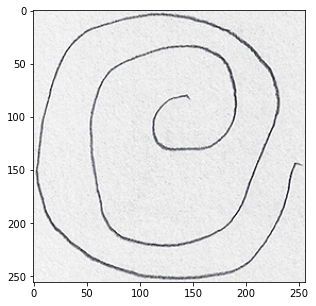

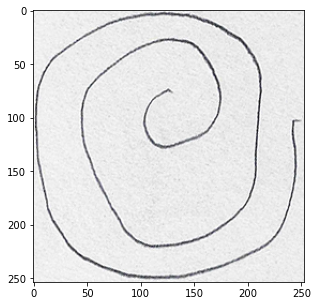

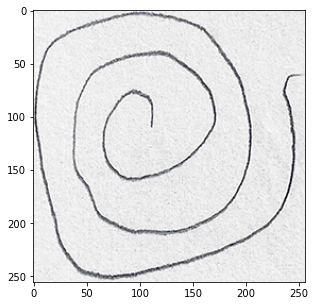

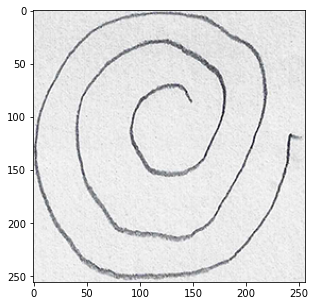

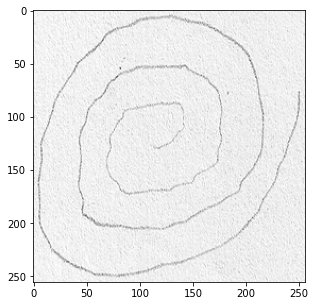

In [168]:
inputfolder="Training/healthy"
i=1
folderlen=len(inputfolder)
for img in glob.glob(inputfolder + "/*.png"):
    if i <=5:
        imageview(img)
        i+=1

Image: Training/parkinson/parkinson (1).png Image Size: (256, 256, 3)
Image: Training/parkinson/parkinson (10).png Image Size: (256, 256, 3)
Image: Training/parkinson/parkinson (11).png Image Size: (256, 256, 3)
Image: Training/parkinson/parkinson (12).png Image Size: (256, 256, 3)
Image: Training/parkinson/parkinson (13).png Image Size: (256, 256, 3)


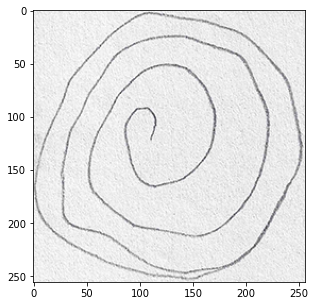

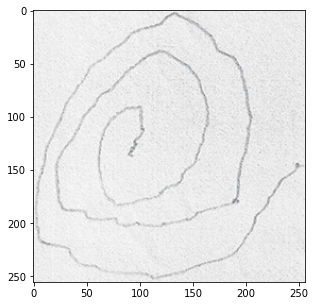

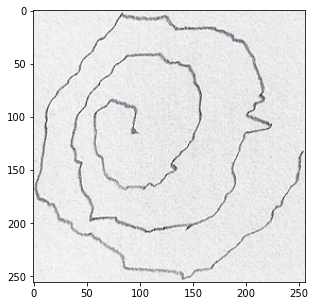

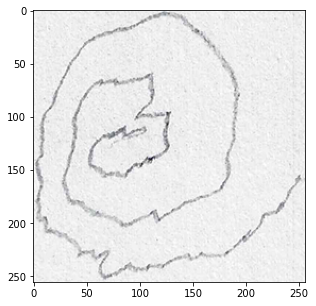

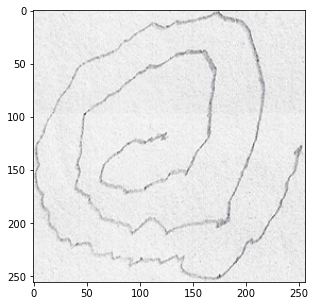

In [169]:
inputfolder="Training/parkinson"
i=1
folderlen=len(inputfolder)
for img in glob.glob(inputfolder + "/*.png"):
    if i <=5:
        imageview(img)
        i+=1

In [31]:
src = "ImagesParkinson/Training/"

train_validation_ratio = 5


workspaceblobstore = ws.get_default_datastore().name
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")
json_line_sample = \
    {
        "image_url": "AmlDatastore://" + workspaceblobstore + "/"
                     + os.path.basename(os.path.dirname(src)),
        "label": "",
        "label_confidence": 1.0
    }

index = 0
with open(train_annotations_file, 'w') as train_f:
    with open(validation_annotations_file, 'w') as validation_f:
        for className in os.listdir(src):
            subDir = src + className
            if not os.path.isdir(subDir):
                continue
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing ImagesParkinson/Training/healthy
Parsing ImagesParkinson/Training/parkinson


In [33]:
ds = ws.get_default_datastore()
ds.upload(src_dir='./ImagesParkinson/Training/', target_path='ImagesParkinson/Training')

Uploading an estimated of 96 files
Uploading ./ImagesParkinson/Training/train_annotations.jsonl
Uploaded ./ImagesParkinson/Training/train_annotations.jsonl, 1 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/validation_annotations.jsonl
Uploaded ./ImagesParkinson/Training/validation_annotations.jsonl, 2 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/healthy/healthy (1).png
Uploaded ./ImagesParkinson/Training/healthy/healthy (1).png, 3 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/healthy/healthy (48).png
Uploaded ./ImagesParkinson/Training/healthy/healthy (48).png, 4 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/healthy/healthy (49).png
Uploaded ./ImagesParkinson/Training/healthy/healthy (49).png, 5 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/healthy/healthy (50).png
Uploaded ./ImagesParkinson/Training/healthy/healthy (50).png, 6 files out of an

$AZUREML_DATAREFERENCE_42cc70ef8fce4589aad9a9c29b58a046

In [34]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

training_dataset_name = 'ParkinsonTrainingDataset'
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('ImagesParkinson/Training/train_annotations.jsonl'))
    training_dataset = training_dataset.register(workspace=ws, name=training_dataset_name)
    
validation_dataset_name = "ParkinsonValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print('Found the validation dataset', validation_dataset_name)
else:
    validation_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('ImagesParkinson/Training/validation_annotations.jsonl'))
    validation_dataset = validation_dataset.register(workspace=ws, name=validation_dataset_name)

print()
print("Training dataset name:" + training_dataset.name)
print("Validation dataset name:" + validation_dataset.name)


Training dataset name:ParkinsonTrainingDataset
Validation dataset name:ParkinsonValidationDataset


In [35]:
df=training_dataset.to_pandas_dataframe()

In [36]:
df.shape

(75, 3)

In [37]:
df.dtypes

image_url            object
label                object
label_confidence    float64
dtype: object

In [38]:
df.head()

,image_url,label,label_confidence
0,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0
1,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0
2,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0
3,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0
4,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0


In [39]:
df['label'].value_counts()

parkinson    38
healthy      37
Name: label, dtype: int64

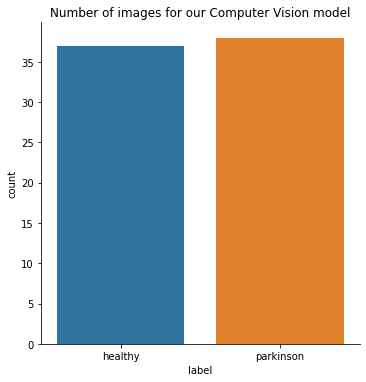

In [40]:
sns.catplot(x="label", kind="count", data=df, height=5).set(title='Number of images for our Computer Vision model')

In [41]:
df['label'].value_counts(normalize=True)

parkinson    0.506667
healthy      0.493333
Name: label, dtype: float64

In [52]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, RandomParameterSampling, BayesianParameterSampling
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    'model': choice(
        {
            'model_name': choice('seresnext'),
            'learning_rate': uniform(0.0001, 0.01),
            'optimizer': choice('sgd', 'adam'),
            'layers_to_freeze': choice(1, 2, 3, 4),

        },
        {
            'model_name': choice('resnet50'),
            'resize_size': choice(128, 256),
        },
        
        {
            'model_name': choice('mobilenetv2'),
            'learning_rate': uniform(0.0001, 0.01),
            'optimizer': choice('sgd', 'adam'),
            'layers_to_freeze': choice(0, 2, 4),

        },
        
          {
            'model_name': choice('resnet34'),
            'learning_rate': uniform(0.0001, 0.01),
            'layers_to_freeze': choice(1, 2, 4),
        },
        {
            'model_name': choice('resnet18'),
            'learning_rate': uniform(0.0001, 0.01),
            'layers_to_freeze': choice(1, 2, 4),
        },
        {
            'model_name': choice('resnet50'),
            'learning_rate': uniform(0.0001, 0.01),
            'layers_to_freeze': choice(1, 2, 4),
        },
    )
}

tuning_settings = {
    'iterations': 20, 
    'max_concurrent_iterations': 4, 
    'hyperparameter_sampling': RandomParameterSampling(parameter_space),  
    'policy': BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=6)
}

automl_image_config = AutoMLImageConfig(task='image-classification',
                                        compute_target=compute_target,
                                        training_data=training_dataset,
                                        validation_data=validation_dataset,
                                        primary_metric='accuracy',
                                        **tuning_settings)

In [ ]:
automl_image_run = experiment.submit(automl_image_config)
automl_image_run.wait_for_completion(wait_post_processing=True) 

In [56]:
automlvisionmetrics = automl_image_run.get_metrics()
automlvisionmetrics

{'log_loss': [0.86431,
  0.63019,
  0.61221,
  0.72615,
  0.66849,
  0.66659,
  0.55323,
  0.45584,
  0.392,
  0.32462,
  0.29444,
  0.28342,
  0.28273,
  0.28005,
  0.27604],
 'f1_score_micro': [0.52632,
  0.68421,
  0.57895,
  0.57895,
  0.57895,
  0.68421,
  0.68421,
  0.68421,
  0.73684,
  0.94737,
  0.94737,
  0.89474,
  0.89474,
  0.89474,
  0.89474],
 'recall_score_micro': [0.52632,
  0.68421,
  0.57895,
  0.57895,
  0.57895,
  0.68421,
  0.68421,
  0.68421,
  0.73684,
  0.94737,
  0.94737,
  0.89474,
  0.89474,
  0.89474,
  0.89474],
 'average_precision_score_weighted': [0.7676,
  0.8157,
  0.9027,
  0.93367,
  0.97016,
  0.98012,
  0.98012,
  0.98995,
  0.98995,
  0.98995,
  0.98995,
  0.98995,
  0.98995,
  0.98995,
  0.98995],
 'recall_score_macro': [0.5,
  0.68333,
  0.55556,
  0.55556,
  0.55556,
  0.66667,
  0.66667,
  0.66667,
  0.72222,
  0.94444,
  0.94444,
  0.89444,
  0.89444,
  0.89444,
  0.89444],
 'average_precision_score_micro': [0.65645,
  0.81392,
  0.77475,
  0

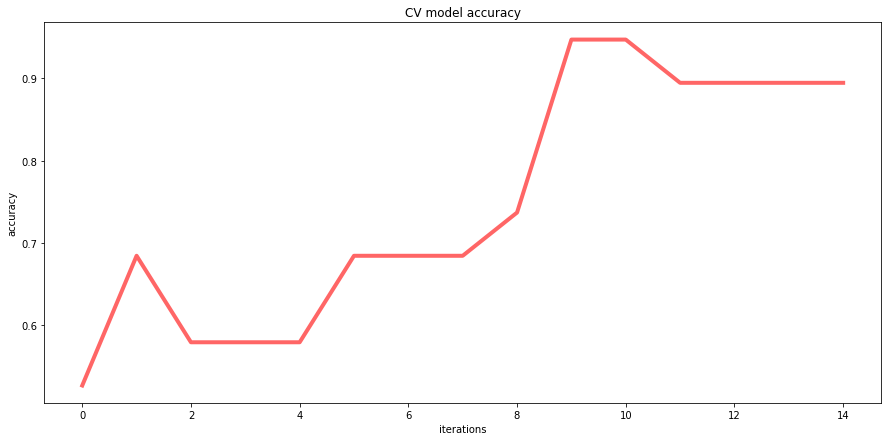

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot(automlvisionmetrics['accuracy'], 'r-', lw=4, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('CV model accuracy', fontsize=12)
plt.savefig('accuracy.jpg', dpi=150)
automl_image_run.log_image(name='accuracy.jpg', plot=plt)
plt.show()